In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# '''
# Desc:  the multi-step  LSTM model of nino index prediction, implemented by keras
# DataSource: https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/
# Reference: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Author: Kris Peng
# Date: 2018/07/24
# '''

In [67]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.models import load_model
from numpy import array
import os.path

In [88]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
    
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_values = diff_values
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()

    # single layer LSTM
    # model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))

    # multi layer LSTM
    model.add(LSTM(n_neurons, return_sequences=False, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    #     model.add(LSTM(n_neurons))

    # MLP Model
    # model.add(Dense(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), activation='relu'))

    # multi layer
    # model.add(Dense(n_neurons))
    # model.add(Flatten())

    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())

    # fit network, stateful version 
    # for i in range(nb_epoch):
    #     history = model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
    #     model.reset_states()

    history = model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)
    pyplot.plot(history.history['loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    sum_rmse = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print("%.3f" % rmse)
        # print('t+%d RMSE: %f' % ((i+1), rmse))
        sum_rmse.append(rmse) 
    print("%.3f" % ((sum_rmse[0]+sum_rmse[1]+sum_rmse[2]+sum_rmse[3]+sum_rmse[4]+sum_rmse[5])/6))
    print("%.3f" % ((sum_rmse[0]+sum_rmse[1]+sum_rmse[2]+sum_rmse[3]+sum_rmse[4]+sum_rmse[5]+sum_rmse[6]+sum_rmse[7]+sum_rmse[8])/9))
    print("%.3f" % ((sum_rmse[0]+sum_rmse[1]+sum_rmse[2]+sum_rmse[3]+sum_rmse[4]+sum_rmse[5]+sum_rmse[6]+sum_rmse[7]+sum_rmse[8]+sum_rmse[9]+sum_rmse[10]+sum_rmse[11])/12))
    # print('6 month RMSE Avg: %f' % ((sum_rmse[0]+sum_rmse[1]+sum_rmse[2]+sum_rmse[3]+sum_rmse[4]+sum_rmse[5])/6))
    # print('9 month RMSE Avg: %f' % ((sum_rmse[0]+sum_rmse[1]+sum_rmse[2]+sum_rmse[3]+sum_rmse[4]+sum_rmse[5]+sum_rmse[6]+sum_rmse[7]+sum_rmse[8])/9))
    # print('12 month RMSE Avg: %f' % ((sum_rmse[0]+sum_rmse[1]+sum_rmse[2]+sum_rmse[3]+sum_rmse[4]+sum_rmse[5]+sum_rmse[6]+sum_rmse[7]+sum_rmse[8]+sum_rmse[9]+sum_rmse[10]+sum_rmse[11])/12))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test, linestyle = None):
    # plot the entire dataset in blue
    pyplot.figure(figsize=(40, 20))
    pyplot.plot(series.values, label='observed')
    pyplot.title("oni_singlevariate_multistep_timeseries")
    pyplot.legend(loc='upper right')
    # plot the forecasts in red
    print(len(forecasts))
    for i in range(len(forecasts)):
        if ((324 <= i) and (i <= 348)):
            off_s = len(series) - n_test + i - 1
            off_e = off_s + len(forecasts[i]) + 1
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = [series.values[off_s]] + forecasts[i]
            pyplot.plot(xaxis, yaxis, color='red')
#         if i%n_seq == 0 and i != 0:
#             off_s = len(series) - n_test + i - 1
#             off_e = off_s + len(forecasts[i]) + 1
#             xaxis = [x for x in range(off_s, off_e)]
#             yaxis = [series.values[off_s]] + forecasts[i]
#             pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (1, 10)                   920       
_________________________________________________________________
dense_42 (Dense)             (1, 12)                   132       
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1392/1392 [==============================] - 8s 5ms/step - loss: 0.0697
Epoch 2/10
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0679
Epoch 3/10
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0674
Epoch 4/10
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0670
Epoch 5/10
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0667
Epoch 6/10
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0665
Epoch 7/10
1392/1392 [===========

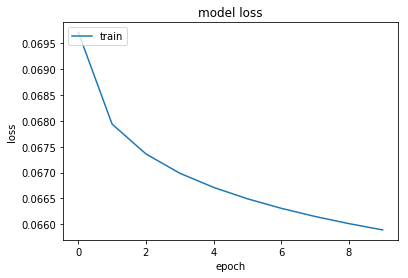

0.243
0.393
0.523
0.629
0.723
0.797
0.852
0.895
0.920
0.940
0.947
0.959
0.551
0.664
0.735
360


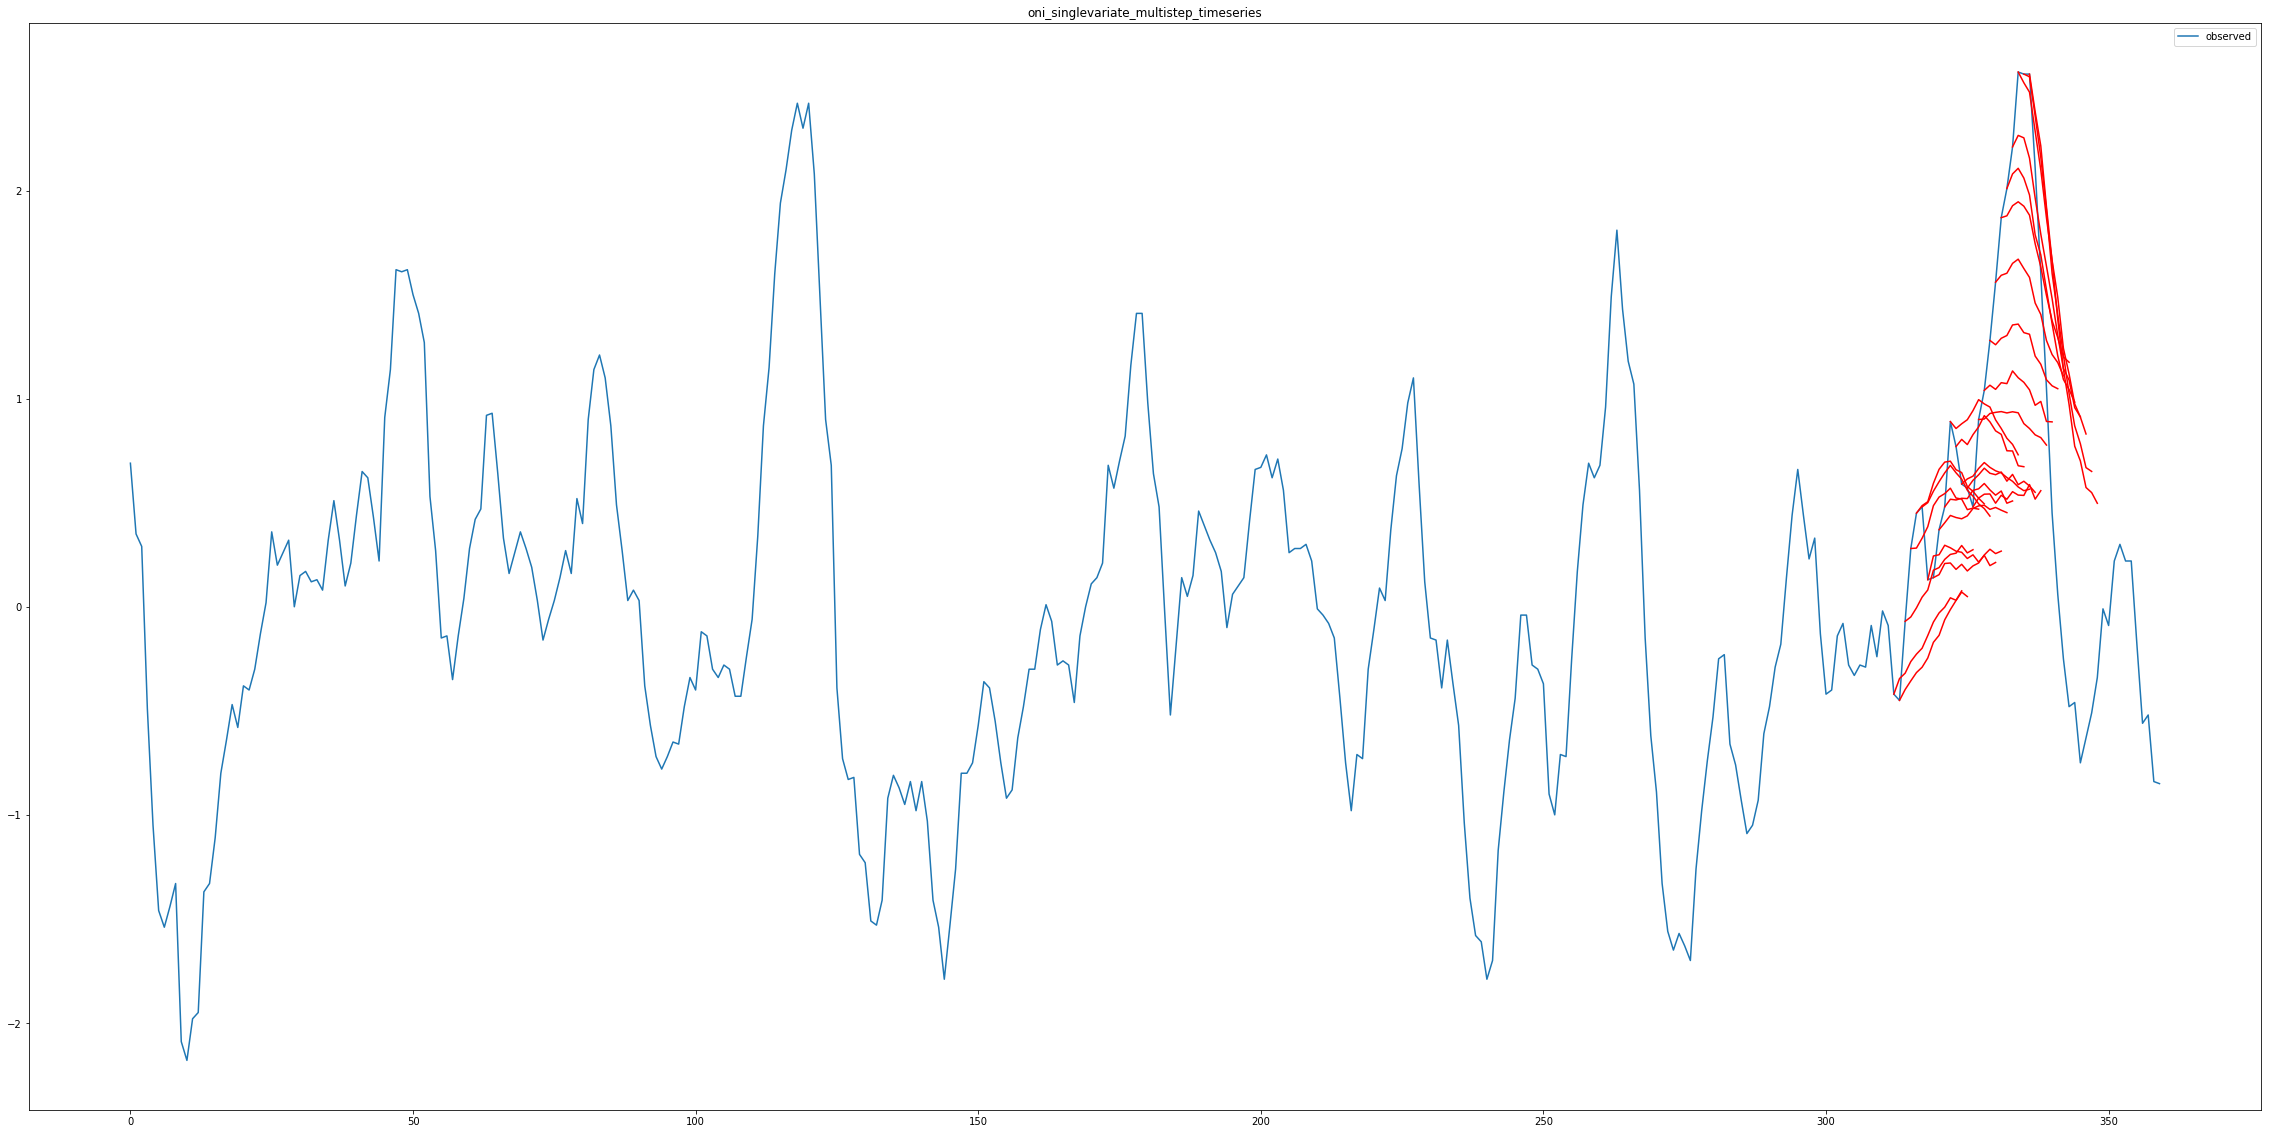

In [90]:
series = read_csv('../../data/oni/csv/nino3_4_anomaly.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# configure
n_lag = 12
n_seq = 12
n_test = 360
n_epochs = 10
n_batch = 1
n_neurons = 10

# LSTM model

# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

# fit model
file_path = 'my_model.h5'

if not os.path.exists(file_path):
    model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
    # model.save(file_path)
else:
    model = load_model(file_path)

# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+11)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+11)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series[-n_test:], forecasts, n_test+11)
